In [1]:
import numpy as np 
import pandas as pd 
import gc
from plotnine import *
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
import utils as u

In [2]:
date_dir = 'date model/'
tr_date_path = date_dir + 'train_date_features.csv'
te_date_path = date_dir + 'test_date_features.csv'

num_dir = 'data/'
tr_num_path = num_dir + 'train_numeric.csv'
te_num_path = num_dir + 'test_numeric.csv'

In [3]:
date_feats = ['Id', 'All_min_date', 'All_max_date', 'All_duration']
num_feats = pd.read_csv('numeric model/0-970 all.csv', index_col = 0).iloc[-15:, 0].to_list()
num_feats.append("Id")

In [4]:
tr = pd.merge(pd.read_csv(tr_date_path, usecols = date_feats,index_col = 0),
              pd.read_csv(tr_num_path, usecols = num_feats), how = 'left', on = 'Id')
te = pd.merge(pd.read_csv(te_date_path, usecols = date_feats,index_col = 0),
              pd.read_csv(te_num_path, usecols = num_feats), how = 'left', on = 'Id')
tr_te = pd.concat([tr, te], axis = 0)
tr_te = tr_te.reset_index(drop=True).reset_index(drop=False)

del tr, te
gc.collect()

0

In [5]:
sorting = ['index', ['All_min_date', 'Id'], ['All_min_date', 'All_max_date'], ['All_max_date', 'Id'], 'Id']
feats = list(set(num_feats) - set(['Id']))

for s in sorting:
  
  col_name = ''.join(s)
  
  tr_te = tr_te.sort_values(by=s, ascending=True)
  
  for feat in feats:
    
    tr_te[col_name + '_prev_' + feat] = tr_te[feat].shift(1).fillna(9999999)
    tr_te[col_name + '_next_' + feat] = tr_te[feat].shift(-1).fillna(9999999)
    
    tr_te['index_prev_diff_' + feat] = tr_te[feat].diff().fillna(9999999)
    tr_te['index_next_diff_' + feat] = tr_te[feat].iloc[::-1].diff().fillna(9999999)

tr_te.shape

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(2367495, 200)

In [6]:
gc.collect()
drop_feats = ['index','All_min_date', 'All_max_date', 'All_duration']
tr_te = tr_te.sort_values(by=['index']).drop(drop_feats, axis=1)

tr = tr_te.iloc[:1183747, :]
te = tr_te.iloc[1183747:, :]
print(tr.shape)
print(te.shape)

(1183747, 196)
(1183748, 196)


In [10]:
# tr.to_csv('numeric model/train_numeric.csv')
# te.to_csv('numeric model/test_numeric.csv')

In [3]:
# tr = pd.read_csv('numeric model/train_numeric.csv', index_col = 0, )
# te = pd.read_csv('numeric model/test_numeric.csv', index_col = 0)

In [4]:
le = pd.read_csv(tr_num_path, usecols = ['Id', 'Response'])
data = pd.merge(tr, le, how = 'left', on = 'Id')

np.random.seed(10)
data = data.sample(frac = 1)
gc.collect()

0

In [5]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 195)
(1183747,)


In [157]:
def best_thr_mcc(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_thr = thresholds[np.argmax(mcc)]
    best_score = mcc.max()
    return best_thr, best_score

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
mcc_score = []
g_means_scores = []
f1_scores = []
thresh = []
evals_result = {}
loss_data = pd.DataFrame()

num_round = 50 # 100
params = {'colsample_bytree':0.8, 
          'eta':0.1, # 0.1
          'max_depth': 12,
          'subsample': 0.9,
          'min_child_weight': 15, 
          'objective': 'binary:logistic',
          'random_state': 71,
          'disable_default_eval_metric': 1
            }
tt = []

for tr_idx, va_idx in kf.split(X, y):
    
    temp_loss_data = pd.DataFrame()

    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, 
                      num_round, 
                      evals = watchlist, 
                      verbose_eval=1, 
                      early_stopping_rounds=10, 
                      evals_result=evals_result,
                      feval = u.evalerror
                      )
    
    va_pred = model.predict(dvalid)
    
    best_thresh, mcc_value= u.best_thr_mcc(va_pred, dvalid)
    y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

    tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
    spec = tn / (tn+fp)
    sens = tp / (tp + fn)
    g_means = np.sqrt(spec * sens)
    fmeasure = f1_score(va_y, y_pred)

    temp_loss_data = pd.DataFrame({'train': list(evals_result['train'].values())[0],
                                   'test': list(evals_result['eval'].values())[0],
                                   'tree': [i+1 for i in range(len(list(evals_result['train'].values())[0]))]})

    print('mcc value: {}'.format(mcc_value))
    print('g_means value: {}'.format(g_means))
    print('f1_score value: {}'.format(fmeasure))
    
    loss_data = pd.concat([loss_data, temp_loss_data], axis = 0).reset_index(drop=True)
    thresh.append(best_thresh)
    mcc_score.append(mcc_value)
    g_means_scores.append(g_means)
    f1_scores.append(fmeasure)

    
    gc.collect()

print('avg_MCC:', round(np.mean(mcc_score), 3))
print('avg_g_means:', round(np.mean(g_means_scores), 3))
print('avg_f1_score:', round(np.mean(f1_scores), 3))


[0]	train-error:-0.35711	eval-error:-0.34478
[1]	train-error:-0.36515	eval-error:-0.34975
[2]	train-error:-0.36530	eval-error:-0.35329
mcc value: 0.35367230363607094
g_means value: 0.41406501420620984
f1_score value: 0.2781706742102782
[0]	train-error:-0.33900	eval-error:-0.32699
[1]	train-error:-0.36364	eval-error:-0.36251
[2]	train-error:-0.36495	eval-error:-0.36238
mcc value: 0.3636510586188536
g_means value: 0.40920462263565294
f1_score value: 0.2767235166946913
avg_MCC: 0.359
avg_g_means: 0.412
avg_f1_score: 0.277


In [4]:
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
# feat_imp.to_csv('numeric model/numeric_xgb_feature_importance.csv')
feat_imp

,feature,scores,score
Id_next_L3_S32_F3850,Id_next_L3_S32_F3850,0.109924,0.000160
index_next_L1_S24_F1498,index_next_L1_S24_F1498,0.138184,0.000202
All_max_dateId_next_L3_S38_F3952,All_max_dateId_next_L3_S38_F3952,0.283569,0.000414
index_prev_L1_S24_F1695,index_prev_L1_S24_F1695,0.482300,0.000703
Id_prev_L3_S32_F3850,Id_prev_L3_S32_F3850,0.501953,0.000732
...,...,...,...
Id_next_L3_S38_F3956,Id_next_L3_S38_F3956,4474.952148,6.527054
All_min_dateId_next_L3_S38_F3960,All_min_dateId_next_L3_S38_F3960,4906.161133,7.156005
Id_next_L3_S38_F3960,Id_next_L3_S38_F3960,6130.832520,8.942280
index_next_diff_L3_S29_F3351,index_next_diff_L3_S29_F3351,7083.632324,10.332010


c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371910751059084.svg


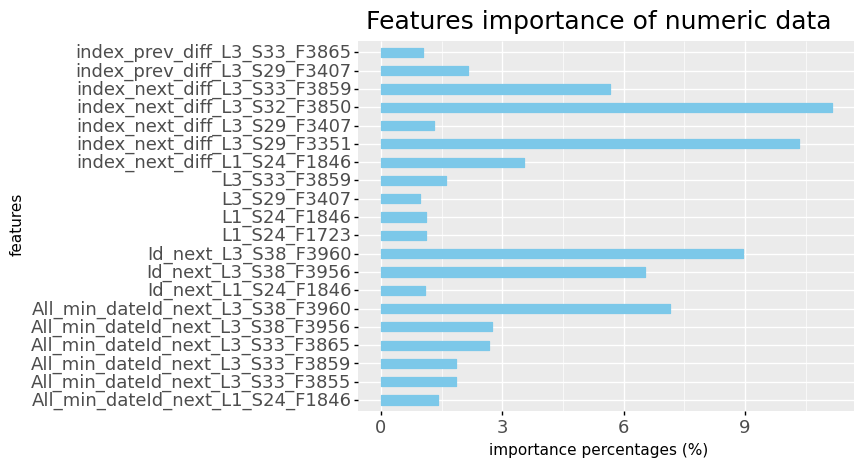

<ggplot: (-9223371910751059084)>

In [5]:
g = (
    ggplot(feat_imp.iloc[-20:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of numeric data')
)
ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

# Analysis important features

In [ ]:
tr = pd.read_csv('numeric model/train_numeric.csv', usecols = ['Id','index_next_diff_L3_S32_F3850', 'index_next_diff_L3_S29_F3351', 'Id_next_L3_S38_F3960'])
tr.replace(9999999, np.nan, inplace = True)
le = pd.read_csv(tr_num_path, usecols = ['Id', 'Response'])
data = pd.merge(tr, le, how = 'left', on = 'Id')

In [ ]:
data_ = data.copy()
cols = ['index_next_diff_L3_S32_F3850', 'index_next_diff_L3_S29_F3351']
data = data_.dropna(subset = ['index_next_diff_L3_S32_F3850'])
data[cols] = np.abs(data[cols])
data['Response'] = data["Response"].astype('category')
col = 'L3_S32_F3850'
num = 0
new_col = 'difference <= {}'.format(num)

data[new_col] = np.where(data['index_next_diff_L3_S32_F3850'] == num, 1, 0)
data[new_col] = data[new_col].astype('category')

propertion = data.groupby('Response')[new_col].value_counts(normalize=True)\
   .unstack()\
   .mul(100)\
   .round(2)\
   .fillna(0)
good_pro = propertion.iloc[0, 0]
ng_pro = propertion.iloc[1, 0]
propertion

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 341'. Pick better value with 'binwidth'.


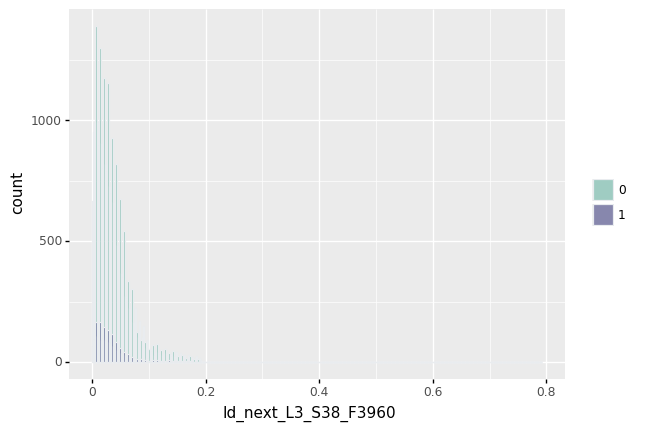

<ggplot: (-9223371910708677464)>

In [139]:
g = (
    ggplot(data.dropna(subset = ['index_next_diff_L3_S32_F3850']), aes(x = 'index_next_diff_L3_S32_F3850', fill = 'Response')) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values= ["#69b3a2", "#404080"]) +
    labs(fill="")
)
g

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371910725460316.svg


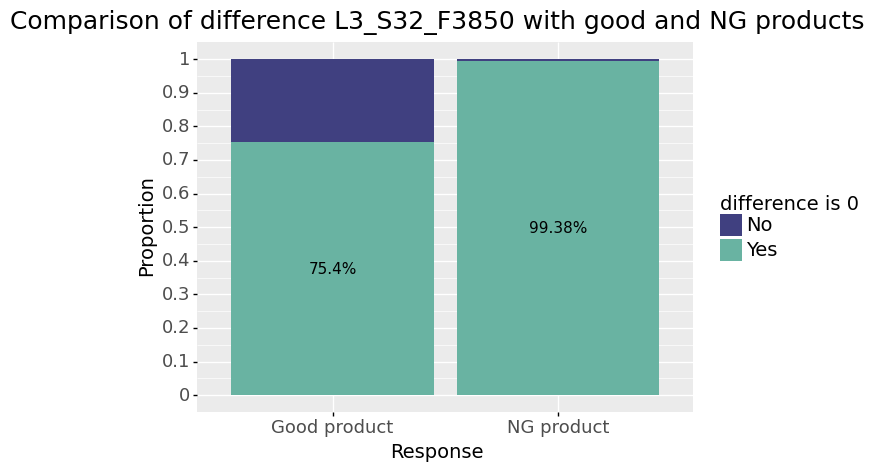

<ggplot: (-9223371910725460316)>

In [136]:
g = (
    ggplot(data, aes(x = 'Response', fill = new_col))
    + geom_bar(position = 'fill')
    + scale_y_continuous(breaks = np.linspace(0, 1, 11))
    + scale_x_discrete(labels=["Good product", 'NG product'])
    + theme(axis_text_x=element_text(size=13),
            axis_text_y=element_text(size=13),
            axis_title=element_text(size=14),
            plot_title=element_text(size=18),
            legend_text = element_text(size = 14),
            legend_title = element_text(size = 14)
    )
    + scale_fill_manual(values= ["#404080", "#69b3a2"], labels = ['No', 'Yes'])
    + labs(y = 'Proportion')
    + annotate("text", x = 1, y = good_pro/200, label = "{}%".format(good_pro))
    + annotate("text", x = 2, y = ng_pro/200, label = "{}%".format(ng_pro))
    + ggtitle('Comparison of difference {} with good and NG products'.format(col))

)
ggsave(file="Comparison of Id difference with good and NG products.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')

g